# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [3]:
# ‚úÖ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ìè¨Ìï®)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                     # ÌÅ¨Î°≠ Ï†Ñ Ïó¨Ïú† Í≥µÍ∞Ñ ÌôïÎ≥¥
    transforms.CenterCrop(224),                        # Ï§ëÏã¨Î∂Ä ÌÅ¨Î°≠ (Ìèê Ï§ëÏã¨)
    transforms.RandomHorizontalFlip(p=0.5),            # Ï¢åÏö∞ Î∞òÏ†Ñ Ï¶ùÍ∞ï
    transforms.RandomRotation(10),                     # ÌöåÏ†Ñ Ï¶ùÍ∞ï
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Î∞ùÍ∏∞/ÎåÄÎπÑ Ï¶ùÍ∞ï
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],         # ImageNet ÌèâÍ∑†
                         [0.229, 0.224, 0.225])         # ImageNet ÌëúÏ§ÄÌé∏Ï∞®
])

# ‚úÖ Í≤ÄÏ¶ù Î∞è ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (Ï¶ùÍ∞ï ÏóÜÏù¥ Ï†ïÍ∑úÌôîÎßå)
eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ‚úÖ Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎî©
train_dataset = datasets.ImageFolder("C:/DL/data/chest_xray/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("C:/DL/data/chest_xray/val", transform=eval_transform)
test_dataset  = datasets.ImageFolder("C:/DL/data/chest_xray/test", transform=eval_transform)

# ‚úÖ Îç∞Ïù¥ÌÑ∞Î°úÎçî ÏÑ§Ï†ï
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

# Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞

In [6]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EfficientNet-b0 Î∂àÎü¨Ïò§Í∏∞
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 2)  # ÌÅ¥ÎûòÏä§ Ïàò: NORMAL vs PNEUMONIA
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


# ÌïôÏäµ Î£®ÌîÑ

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import efficientnet_b0
import time

# Î™®Îç∏, ÏÜêÏã§ Ìï®Ïàò, ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # ÌÅ¥ÎûòÏä§ ÏàòÏóê ÎßûÍ≤å ÏàòÏ†ï
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# EarlyStopping ÏÑ§Ï†ï
best_val_loss = float('inf')
patience = 5
trigger_times = 0

# DataLoader ÏµúÏ†ÅÌôî
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)

# ÌïôÏäµ ÏãúÏûë
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Í≤ÄÏ¶ù Îã®Í≥Ñ
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # ÌïôÏäµÎ•† Ï°∞Ï†ï
    scheduler.step(val_loss)

    # EarlyStopping Ï≤¥ÌÅ¨
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")  # Î™®Îç∏ Ï†ÄÏû•
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

end_time = time.time()
print(f"Ï¥ù ÌïôÏäµ ÏãúÍ∞Ñ: {(end_time - start_time)/60:.2f}Î∂Ñ")

C:\Users\82104\AppData\Local\Temp\ipykernel_47508\3553143447.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\82104\AppData\Local\Temp\ipykernel_47508\3553143447.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\82104\AppData\Local\Temp\ipykernel_47508\3553143447.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | Train Loss: 0.1848 | Val Loss: 0.2755 | Val Acc: 87.50%
Epoch 02 | Train Loss: 0.0716 | Val Loss: 0.0595 | Val Acc: 100.00%
Epoch 03 | Train Loss: 0.0557 | Val Loss: 0.4115 | Val Acc: 75.00%
Epoch 04 | Train Loss: 0.0370 | Val Loss: 0.0597 | Val Acc: 100.00%
Epoch 05 | Train Loss: 0.0387 | Val Loss: 0.7459 | Val Acc: 62.50%
Epoch 06 | Train Loss: 0.0315 | Val Loss: 0.2002 | Val Acc: 93.75%
Epoch 07 | Train Loss: 0.0269 | Val Loss: 0.0447 | Val Acc: 100.00%
Epoch 08 | Train Loss: 0.0242 | Val Loss: 0.2033 | Val Acc: 81.25%
Epoch 09 | Train Loss: 0.0181 | Val Loss: 0.0414 | Val Acc: 100.00%
Epoch 10 | Train Loss: 0.0171 | Val Loss: 0.0783 | Val Acc: 100.00%
Epoch 11 | Train Loss: 0.0135 | Val Loss: 0.0221 | Val Acc: 100.00%
Epoch 12 | Train Loss: 0.0109 | Val Loss: 0.1047 | Val Acc: 93.75%
Epoch 13 | Train Loss: 0.0119 | Val Loss: 0.0722 | Val Acc: 93.75%
Epoch 14 | Train Loss: 0.0114 | Val Loss: 0.1165 | Val Acc: 93.75%
Epoch 15 | Train Loss: 0.0084 | Val Loss: 0.1244 | Val A

# Í≤ÄÏ¶ù Î∞è ÌÖåÏä§Ìä∏


Validation F1 Score (weighted): 1.00

Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



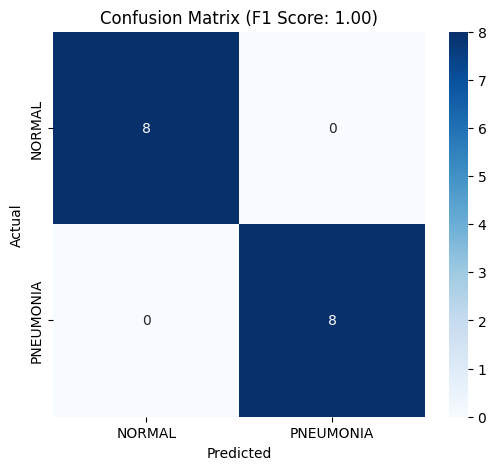

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].


ÏòàÏ∏° Í≤∞Í≥º: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1], Ï†ïÎãµ: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


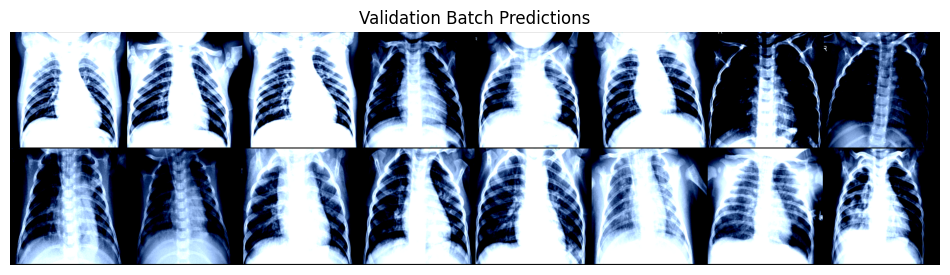


ÏµúÏ¢Ö Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: 100.00%


In [10]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision

# ‚úÖ Î™®Îç∏ Î°úÎìú Î∞è ÌèâÍ∞Ä Î™®Îìú ÏÑ§Ï†ï
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# ‚úÖ ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
y_true = []
y_pred = []

# üîç Í≤ÄÏ¶ù ÌèâÍ∞Ä
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ‚úÖ F1 Score Î∞è Î¶¨Ìè¨Ìä∏ Ï∂úÎ†•
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nValidation F1 Score (weighted): {f1:.2f}")

target_names = train_dataset.classes
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# ‚úÖ Confusion Matrix ÏãúÍ∞ÅÌôî
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (F1 Score: {f1:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# üîç ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
total_pred = 0

with torch.no_grad():
    for data, label in val_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        pred = torch.max(pred, 1)[1]

        total_pred += torch.sum(pred == label).item()

        print(f'ÏòàÏ∏° Í≤∞Í≥º: {pred.cpu().numpy()}, Ï†ïÎãµ: {label.cpu().numpy()}')

        images_data = torchvision.utils.make_grid(data.cpu())
        plt.figure(figsize=(12, 6))
        plt.imshow(images_data.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Validation Batch Predictions")
        plt.show()

# ‚úÖ ÏµúÏ¢Ö Ï†ïÌôïÎèÑ Ï∂úÎ†•
val_accuracy = total_pred / len(val_loader.dataset)
print(f'\nÏµúÏ¢Ö Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: {val_accuracy:.2%}')


Validation F1 Score (weighted): 1.00

Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

ÏòàÏ∏° Í≤∞Í≥º: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1], Ï†ïÎãµ: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].


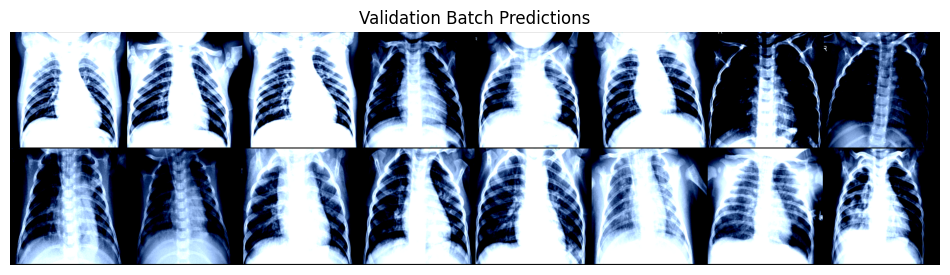


ÏµúÏ¢Ö Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: 100.00%


In [11]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import torch
import io

# ‚úÖ SummaryWriter Ï¥àÍ∏∞Ìôî
writer = SummaryWriter(log_dir='runs/val_analysis')

# ‚úÖ Î™®Îç∏ Î°úÎìú Î∞è ÌèâÍ∞Ä Î™®Îìú ÏÑ§Ï†ï
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# ‚úÖ ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
y_true = []
y_pred = []

# üîç Í≤ÄÏ¶ù ÌèâÍ∞Ä
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ‚úÖ F1 Score Î∞è Î¶¨Ìè¨Ìä∏ Ï∂úÎ†•
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nValidation F1 Score (weighted): {f1:.2f}")
writer.add_scalar('F1_Score/weighted', f1)

target_names = train_dataset.classes
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# ‚úÖ Confusion Matrix ÏãúÍ∞ÅÌôî Î∞è TensorBoard Í∏∞Î°ù
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (F1 Score: {f1:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# üîÑ Ïù¥ÎØ∏ÏßÄ Î≤ÑÌçºÏóê Ï†ÄÏû• ÌõÑ TensorBoardÏóê Í∏∞Î°ù
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
conf_matrix_img = torchvision.transforms.ToTensor()(plt.imread(buf))
writer.add_image('Confusion_Matrix', conf_matrix_img)
plt.close()

# üîç ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî Î∞è Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
total_pred = 0

with torch.no_grad():
    for i, (data, label) in enumerate(val_loader):
        data, label = data.to(device), label.to(device)
        pred = model(data)
        pred = torch.max(pred, 1)[1]

        total_pred += torch.sum(pred == label).item()

        print(f'ÏòàÏ∏° Í≤∞Í≥º: {pred.cpu().numpy()}, Ï†ïÎãµ: {label.cpu().numpy()}')

        # ‚úÖ Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî Î∞è TensorBoard Í∏∞Î°ù
        images_data = torchvision.utils.make_grid(data.cpu())
        writer.add_image(f'Batch_{i}/Images', images_data)

        # Î°úÏª¨ÏóêÏÑúÎèÑ Î≥¥Í∏∞ ÏõêÌï† Í≤ΩÏö∞
        plt.figure(figsize=(12, 6))
        plt.imshow(images_data.permute(1, 2, 0))
        plt.axis("off")
        plt.title("Validation Batch Predictions")
        plt.show()

# ‚úÖ ÏµúÏ¢Ö Ï†ïÌôïÎèÑ Ï∂úÎ†• Î∞è Í∏∞Î°ù
val_accuracy = total_pred / len(val_loader.dataset)
print(f'\nÏµúÏ¢Ö Í≤ÄÏ¶ù Ï†ïÌôïÎèÑ: {val_accuracy:.2%}')
writer.add_scalar('Accuracy/val', val_accuracy)

# ‚úÖ SummaryWriter Ï¢ÖÎ£å
writer.close()
